In [1]:
from inference_utils import extract_level_representation, fix_level_format
from create_img import convert_kidicarus_to_png, convert_loderunner_to_png, convert_mario_to_png, convert_rainbowisland_to_png

In [2]:
from unsloth import FastLanguageModel
import torch
import os
from huggingface_hub import login
from unsloth.chat_templates import get_chat_template
from datasets import load_dataset
from unsloth.chat_templates import standardize_sharegpt
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported
from unsloth.chat_templates import train_on_responses_only

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/home/pressprexx/miniconda3/envs/unsloth/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
print("<|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>\n<|im_start|>user\nCreate a level<|im_end|>\n<|im_start|>assistant\n....BB..BB..BB..BB..BB..BB......\n....BB..BB..BB..BB..BB..BB......\n................................\n................................\n................................\n................................\nBBBBBBBBBBBB........BBBBBBBBBBBB\nBBBBBBBBBBBB........BBBBBBBBBBBB\nBBBB........................BBBB\nBBBB........................BBBB\nBBBB........................BBBB\nBBBB...BB......BB......BB...BBBB\n.......BB......BB......BB.......\n................................\n................................\n................................\n...BBBBBBBBBBBBBBBBBBBBBBBBBB...\n...BBBBBBBBBBBBBBBBBBBBBBBBBB...\n................................\n................................\n................................\n................................\n................................\n.........BB..BB..BB..BB.........\n.........BB..BB..BB..BB.........\n................................\n................................\n................................\n..........BB..BB..BB............\n..........BB..BB..BB............\n................................\n................................\n................................\n...........BB..BB..BB...........\n...........BB..BB..BB...............<|im_end|>")

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
Create a level<|im_end|>
<|im_start|>assistant
....BB..BB..BB..BB..BB..BB......
....BB..BB..BB..BB..BB..BB......
................................
................................
................................
................................
BBBBBBBBBBBB........BBBBBBBBBBBB
BBBBBBBBBBBB........BBBBBBBBBBBB
BBBB........................BBBB
BBBB........................BBBB
BBBB........................BBBB
BBBB...BB......BB......BB...BBBB
.......BB......BB......BB.......
................................
................................
................................
...BBBBBBBBBBBBBBBBBBBBBBBBBB...
...BBBBBBBBBBBBBBBBBBBBBBBBBB...
................................
................................
................................
................................
................................
.........BB..BB..BB..BB.........
.........BB..BB..BB..BB.........
.............

In [4]:
save_model_name = "../models/rainbow_islands/Qwen-2.5-14b-horizontal-newline-1epoch-rainbow_island-teste1"

In [5]:
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

if True:
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = save_model_name, # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

==((====))==  Unsloth 2025.3.19: Fast Qwen2 patching. Transformers: 4.51.3.
   \\   /|    NVIDIA GeForce RTX 4060 Ti. Num GPUs = 1. Max memory: 15.697 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]
Unsloth 2025.3.19 patched 48 layers with 48 QKV layers, 48 O layers and 48 MLP layers.


In [6]:
messages = [
    {"role": "user", "content": "Create a level"},
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, # Must add for generation
    return_tensors = "pt",
).to("cuda")


outputs = model.generate(input_ids = inputs, max_new_tokens = 512, use_cache = True,
                         temperature = 1.2, min_p = 0.1)
response = tokenizer.batch_decode(outputs)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [7]:
print(response[0])

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
Create a level<|im_end|>
<|im_start|>assistant
BBBBBB..........................
BBBBBB..........................
................................
................................
....BBBBBBBBBB..BBBBBBBBBBBB....
....BBBBBBBBBB..BBBBBBBBBBBB....
................................
................................
................................
................................
................................
................................
.........BBBBBBBBBBBBBB.........
.........BBBBBBBBBBBBBB.........
.........BB..........BB.........
.........BB..........BB.........
.........BB..........BB.........
.........BB..........BB.........
................................
................................
................................
................................
....BBBBBBBBBB..BBBBBBBBBBBB....
....BBBBBBBBBB..BBBBBBBBBBBB....
................................
.............

In [8]:
level = extract_level_representation(response[0], model_type="qwen-2.5", orientation="horizontal", separator="\n")

In [9]:
print(level)

BBBBBB..........................
BBBBBB..........................
................................
................................
....BBBBBBBBBB..BBBBBBBBBBBB....
....BBBBBBBBBB..BBBBBBBBBBBB....
................................
................................
................................
................................
................................
................................
.........BBBBBBBBBBBBBB.........
.........BBBBBBBBBBBBBB.........
.........BB..........BB.........
.........BB..........BB.........
.........BB..........BB.........
.........BB..........BB.........
................................
................................
................................
................................
....BBBBBBBBBB..BBBBBBBBBBBB....
....BBBBBBBBBB..BBBBBBBBBBBB....
................................
................................
................................
................................
................................
.........BBBBBBBBBBBBBB.........
.........B

In [10]:
fixed_level = fix_level_format(level, empty_space='.')
print(fixed_level)

BBBBBB......................
BBBBBB......................
............................
............................
....BBBBBBBBBB..BBBBBBBBBBBB
....BBBBBBBBBB..BBBBBBBBBBBB
............................
............................
............................
............................
............................
............................
.........BBBBBBBBBBBBBB.....
.........BBBBBBBBBBBBBB.....
.........BB..........BB.....
.........BB..........BB.....
.........BB..........BB.....
.........BB..........BB.....
............................
............................
............................
............................
....BBBBBBBBBB..BBBBBBBBBBBB
....BBBBBBBBBB..BBBBBBBBBBBB
............................
............................
............................
............................
............................
.........BBBBBBBBBBBBBB.....
.........BBBBBBBBBBBBBB.....
.........BB..........BB.....
.........BB..........BB.....
.........BB..........BB.....


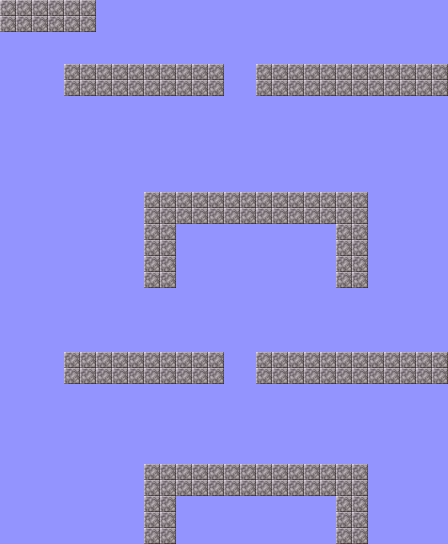

In [11]:
from IPython.display import display

# Call the function and extract the image
img, _, _ = convert_rainbowisland_to_png(fixed_level)

# Display the image in the notebook
display(img)